# 自查询

自查询检索器，顾名思义，是一种能够查询自身的检索器。具体来说，给定任何自然语言查询，检索器使用查询构造 LLM 链来编写结构化查询，然后将该结构化查询应用于其底层 VectorStore。这允许检索器不仅使用用户输入的查询与存储的文档的内容进行语义相似性比较，而且还从对存储的文档的元数据的用户查询中提取过滤器并执行这些过滤器。
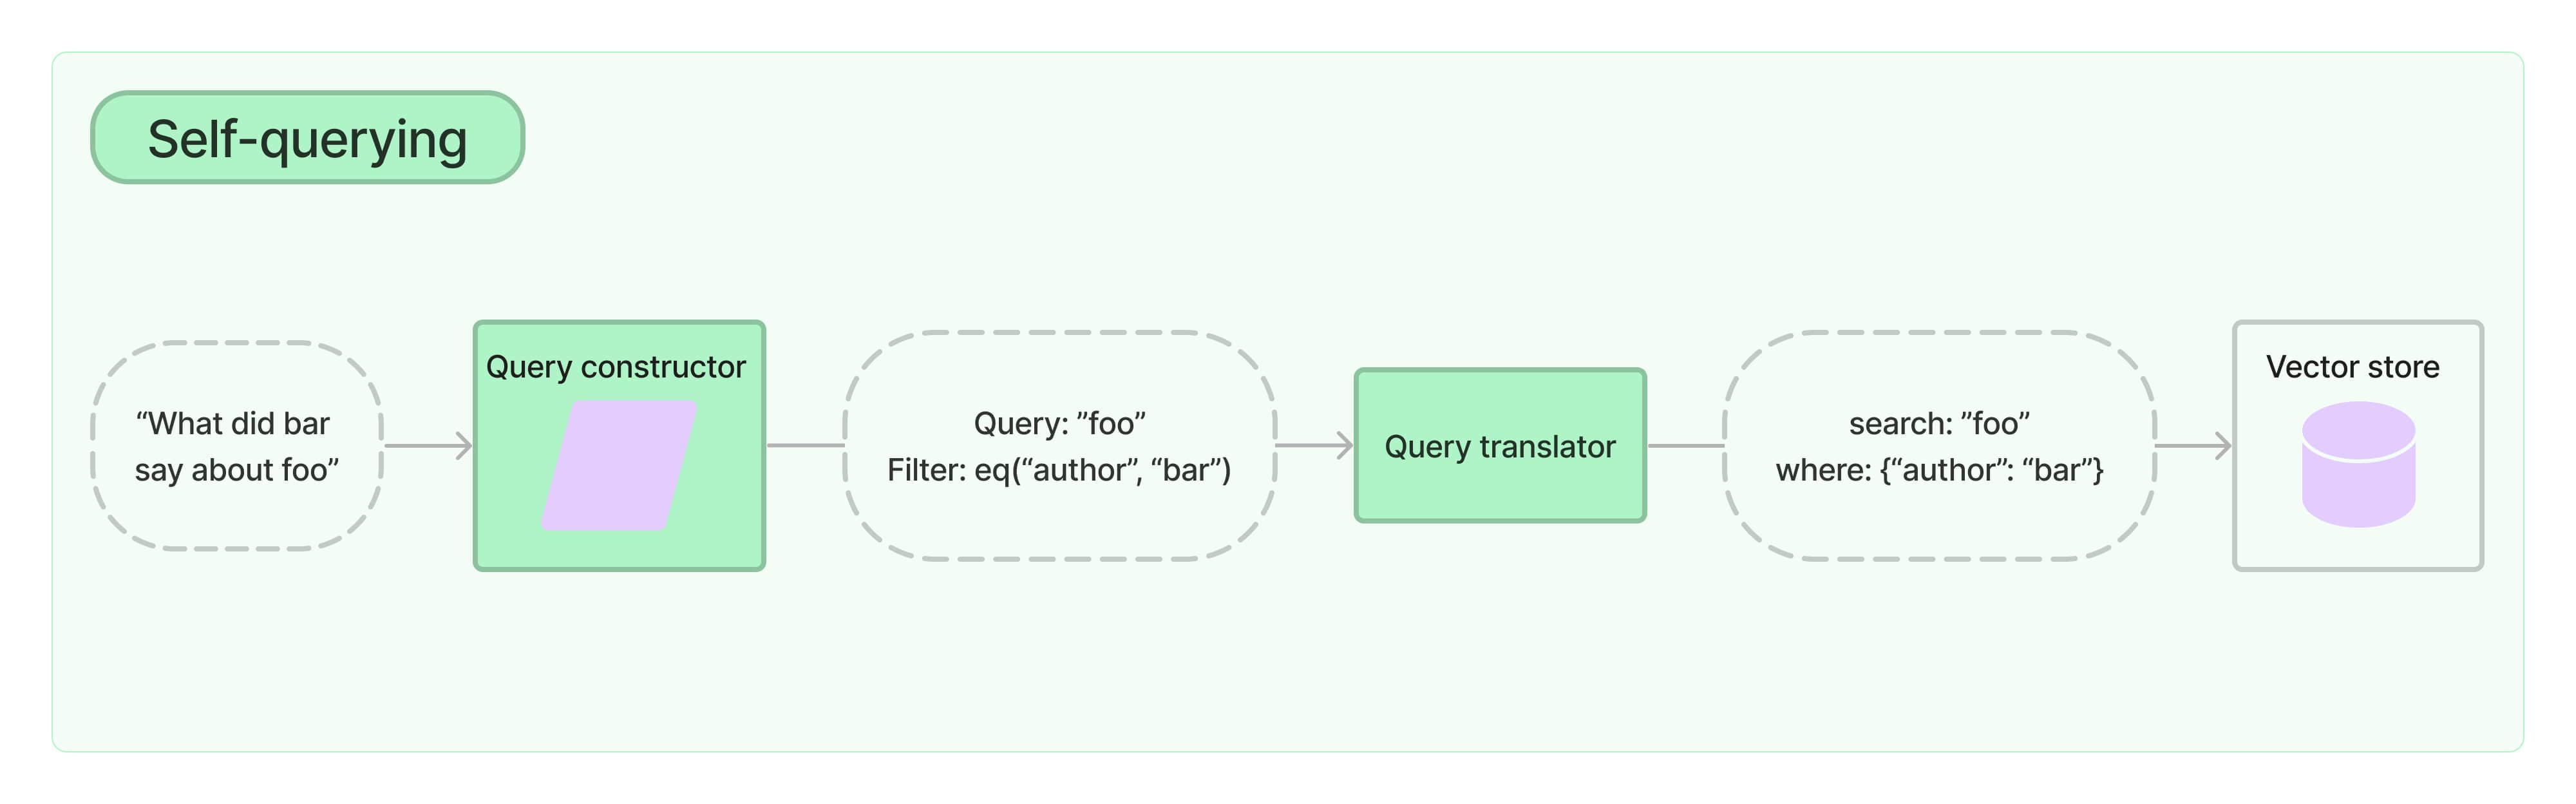

出于演示目的，我们将使用 Chroma 矢量存储。我们创建了一个小型演示文档集，其中包含电影摘要。

注意：自查询检索器要求您安装 lark 软件包。

```
pip install --upgrade --quiet  lark chromadb
```

In [1]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [2]:
docs = [
    Document(
        page_content="一群科学家带回恐龙爆发了混乱",
        metadata={"year": 1993, "rating": 7.7, "genre": "科幻小说"},
    ),
    Document(
        page_content="故事发生在1920年北洋年间中国南方，马邦德花钱买官，购得“萨南康省”的县长一职，坐“马拉的火车”赴任途中遭马匪张麻子一行人伏击",
        metadata={"year": 2010, "director": "姜文", "rating": 8.2},
    ),
    Document(
        page_content="话说孙悟空护送唐三藏前往西天取经，半路却和牛魔王合谋要杀害唐三藏，并偷走了紫霞仙子持有的月光宝盒。观音闻讯赶到，欲除掉孙悟空以免危害苍生。唐三藏慈悲为怀，愿意一命赔一命，感化劣徒，观音遂令孙悟空五百年后投胎做人，赎其罪孽。",
        metadata={"year": 1994, "director": "刘镇伟", "rating": 8.6},
    ),
    Document(
        page_content="故事背景设定在2075年，讲述了太阳即将毁灭，毁灭之后的太阳系已经不适合人类生存，而面对绝境，人类将开启“流浪地球”计划，试图带着地球一起逃离太阳系，寻找人类新家园的故事。",
        metadata={"year": 2019, "director": "郭帆", "rating": 8.3},
    ),
    Document(
        page_content="该片讲述了耿浩和好哥们郝义一场荒诞而有趣的“寻爱之旅”。该片采用双线叙事的手法，以耿浩和康小雨婚姻破裂为叙事的起点，在郝义携耿浩前往剧组送道具途中“寻爱”的故事中，穿插着昔日康小雨孤身前往大理并与耿浩相遇的前尘往事，讲述着在现代生活中不同人群对婚姻、生活与理想的不同追求。",
        metadata={"year": 2014, "genre": "喜剧"},
    ),
]

In [3]:
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
embeddings_path = "D:\\ai\\download\\bge-large-zh-v1.5"
embeddings = HuggingFaceEmbeddings(model_name=embeddings_path)

C:\Users\a4154\AppData\Roaming\Python\Python310\site-packages\transformers\utils\hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
d:\ProgramData\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
vectorstore = Chroma.from_documents(docs, embeddings)

## 创建我们的自查询检索器

现在我们可以实例化我们的检索器。为此，我们需要预先提供一些有关我们的文档支持的元数据字段的信息以及文档内容的简短描述。

In [5]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description='电影的类型。 ["科幻小说","喜剧","剧情片"，"惊悚片","爱情片","动作片","动画片"]之一',
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="电影上映年份",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="电影导演的名字",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="电影评分为 1-10", type="float"
    ),
]

In [6]:
document_content_description = "电影的简要概述"

In [7]:
from langchain_openai import ChatOpenAI, OpenAI
openai_api_key = "EMPTY"
openai_api_base = "http://127.0.0.1:1234/v1"
model = ChatOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    temperature=0.3,
)


In [11]:
retriever = SelfQueryRetriever.from_llm(
    model,
    vectorstore,
    document_content_description,
    metadata_field_info,
    enable_limit=True,
    search_kwargs={"k": 2}
)

In [12]:
# This example only specifies a filter
retriever.invoke("给我推荐一部评分8.5以上的电影")

[Document(page_content='话说孙悟空护送唐三藏前往西天取经，半路却和牛魔王合谋要杀害唐三藏，并偷走了紫霞仙子持有的月光宝盒。观音闻讯赶到，欲除掉孙悟空以免危害苍生。唐三藏慈悲为怀，愿意一命赔一命，感化劣徒，观音遂令孙悟空五百年后投胎做人，赎其罪孽。', metadata={'director': '刘镇伟', 'rating': 8.6, 'year': 1994})]

In [13]:
retriever.invoke("帮我推荐1个关于寻爱之旅的电影")

[Document(page_content='该片讲述了耿浩和好哥们郝义一场荒诞而有趣的“寻爱之旅”。该片采用双线叙事的手法，以耿浩和康小雨婚姻破裂为叙事的起点，在郝义携耿浩前往剧组送道具途中“寻爱”的故事中，穿插着昔日康小雨孤身前往大理并与耿浩相遇的前尘往事，讲述着在现代生活中不同人群对婚姻、生活与理想的不同追求。', metadata={'genre': '喜剧', 'year': 2014}),
 Document(page_content='一群科学家带回恐龙爆发了混乱', metadata={'genre': '科幻小说', 'rating': 7.7, 'year': 1993})]